## Data Processing

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import ast
import openpyxl
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import casual_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
from tqdm.notebook import tqdm
tqdm.pandas()

Code to change progress bar color to dark from tqdm.

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  

### Read Dataset

In [4]:
reddit_df = pd.DataFrame(pd.read_csv('../data/reddit_depression_dataset.csv', index_col=0))
reddit_df.head()

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/13229182.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_df = pd.DataFrame(pd.read_csv('../data/reddit_depression_dataset.csv', index_col=0))


,subreddit,title,body,upvotes,created_utc,num_comments,label
47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,NaN,0.0
47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0
47957,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0
47959,DeepThoughts,"""I want to be like water. I want to slip throu...",NaN,25.0,1.416512e+09,2.0,0.0
47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0


### Data Pre-Processing

In [5]:
reddit_df.shape

(2470778, 7)

In [6]:
reddit_df.dtypes

subreddit        object
title            object
body             object
upvotes         float64
created_utc     float64
num_comments    float64
label           float64
dtype: object

In [7]:
reddit_df.columns

Index(['subreddit', 'title', 'body', 'upvotes', 'created_utc', 'num_comments',
       'label'],
      dtype='object')

Explaining the attriubutes:
- **Subreddit**: The subreddit where the post was shared
- **Title**: The title provided by the user for the post
- **Body**: The content of the post written by the user
- **Upvotes**: The number of upvotes the post received
- **Created UTC**: The time the post was created, given in UTC epoch time
- **Number of Comments**: The total count of comments on the post
- **Label**: The category assigned to the post, where 0 indicates normal and 1 indicates depressed

Checking the subreddit categories:

In [8]:
reddit_df['subreddit'].value_counts()

subreddit
teenagers       1956521
depression       290058
SuicideWatch     190364
happy             24609
DeepThoughts       9163
4                    10
6                     5
5                     5
10                    2
11                    2
8                     2
9                     2
7                     2
16                    2
30                    2
61                    1
107                   1
12                    1
1402326041            1
15                    1
31                    1
101                   1
27                    1
47                    1
Name: count, dtype: int64

According to the original dataset, there should only be the first 5 categories as subreddit categories.

In [9]:
subreddit_grouped = reddit_df.groupby('subreddit')
subreddit_grouped = subreddit_grouped.filter(lambda x: x.name not in ['teenagers', 'depression', 'SuicideWatch', 'happy', 'DeepThoughts'])
subreddit_grouped['subreddit'].value_counts()

subreddit
4             10
5              5
6              5
10             2
30             2
16             2
7              2
9              2
8              2
11             2
1402326041     1
27             1
101            1
31             1
15             1
107            1
61             1
12             1
47             1
Name: count, dtype: int64

In [10]:
subreddit_grouped.count()

subreddit       43
title           43
body            42
upvotes         42
created_utc      0
num_comments     0
label            0
dtype: int64

In [11]:
subreddit_grouped.head(43)

,subreddit,title,body,upvotes,created_utc,num_comments,label
I fucking love 50 and Em.,15,1367017722,174,0.0,NaN,NaN,NaN
Edit: Pictures of not well-known animals could be great :D,6,1376650800,43,0.0,NaN,NaN,NaN
Respect the rules please.,30,1376701449,275,0.0,NaN,NaN,NaN
Please don't give any personal information away that is obviously meant to be confidential over the internet &lt;3,5,1376835553,45,0.0,NaN,NaN,NaN
Edit: People who aren't going back to school yet can tell us if they are looking forward to it or not and tell us why.,5,1376929667,25,0.0,NaN,NaN,NaN
What do,12,1383102207,22,0.0,NaN,NaN,NaN
Then I woke up...idk it was weird.,16,1384694940,9,0.0,NaN,NaN,NaN
song I wrote for my band. Any tips or advice?,5,1385719387,6,0.0,NaN,NaN,NaN
NaN,7,1386027115,43,0.0,NaN,NaN,NaN
Add kiks too :D,4,1386219268,109,0.0,NaN,NaN,NaN


The data here has been scrambled, and is missing its numerical attributes. Thus, we will remove them from the data.

In [12]:
reddit_df.isnull().sum()

subreddit           20
title               23
body            461051
upvotes             64
created_utc        106
num_comments    113977
label              106
dtype: int64

In [13]:
# Filter the dataframe to keep only the specified subreddits
reddit_df2 = reddit_df[reddit_df['subreddit'].isin(['teenagers', 'depression', 'SuicideWatch', 'happy', 'DeepThoughts'])]

# Display the first few rows of the filtered dataframe
reddit_df2['subreddit'].value_counts()

subreddit
teenagers       1956521
depression       290058
SuicideWatch     190364
happy             24609
DeepThoughts       9163
Name: count, dtype: int64

We will not check `title` and `body` as they are ok to be empty. We will fill them with blank values later.

Checking the numerical attributes:

In [14]:
print("Upvotes range:", reddit_df2['upvotes'].min(), reddit_df2['upvotes'].max())
print(reddit_df2['label'].value_counts())

Upvotes range: 4.0 128866.0
label
0.0    1990261
1.0     480411
Name: count, dtype: int64


There is nothing out of the place here. One thing to note is the disproportionality in label groups. We will work on this more in the EDA.

Let's check the missing value count again:

In [15]:
reddit_df2.isnull().sum()

subreddit            0
title                3
body            461030
upvotes             43
created_utc         43
num_comments    113914
label               43
dtype: int64

There are still some missing values. Let's dive a bit deeper.

Checking the date value:

In [16]:
reddit_df2[reddit_df2['created_utc'].isnull()].head(43)

,subreddit,title,body,upvotes,created_utc,num_comments,label
544405,teenagers,Favorite music artist?,I'm just curious since I haven't seen any rap/...,NaN,NaN,NaN,NaN
565840,teenagers,"/r/teenagers, what would be your dream pet?",It can be any animal and it can be the usual s...,NaN,NaN,NaN,NaN
566332,teenagers,What are your beliefs /r/teenagers?,Religious or just normal beliefs will do.,NaN,NaN,NaN,NaN
566520,teenagers,My name is Snapper! What would you have liked ...,New birth name or you could say what nickname ...,NaN,NaN,NaN,NaN
566920,teenagers,How was your first day back at school?,For the ones that obviously had school today &...,NaN,NaN,NaN,NaN
592474,teenagers,Ah shit,I'm have an orthodontist appointment tomorrow ...,NaN,NaN,NaN,NaN
600347,teenagers,I just had the creepiest dream.,In my dream I was coming home from vacation. I...,NaN,NaN,NaN,NaN
606826,teenagers,What do you guys think of my song?,http://m.soundcloud.com/yellow-rockets/iron-ca...,NaN,NaN,NaN,NaN
608772,teenagers,What roles do you have in your group of friends?,For instance in my small group we have a pimp ...,NaN,NaN,NaN,NaN
610758,teenagers,Rate post,As I have not found one for the day I have cre...,NaN,NaN,NaN,NaN


`created_utc` is important to us as we will need it to perform time series analysis and visualization later. Thus, data instances without this crucial attribute should not be left included.

Just to make sure that we are not removing data instances unnecessarily:

In [17]:
missing_counts = reddit_df2[['upvotes', 'created_utc', 'label']].isnull().all(axis=1).sum()
missing_counts

43

The above shows that all rows with missing `upvotes`, `created_utc` and `label` are in the same 43 rows. Thus, we can safely remove them without causing any other issues with the data we want to keep.

In [18]:
# Remove rows with missing 'upvotes', 'created_utc', and 'label'
reddit_df3 = reddit_df2.dropna(subset=['upvotes', 'created_utc', 'label'])
reddit_df3.isnull().sum()

subreddit            0
title                3
body            461029
upvotes              0
created_utc          0
num_comments    113871
label                0
dtype: int64

For the remaining missing attributes, they are optional fields that users can input in posts. Thus, we can fill them in with blank values.

In [19]:
reddit_df3['title'].fillna('', inplace=True)
reddit_df3['body'].fillna('', inplace=True)
reddit_df3['num_comments'].fillna(0.0, inplace=True)
reddit_df3.isnull().sum()

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/2564938363.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reddit_df3['title'].fillna('', inplace=True)
/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/2564938363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['title'].fillna('', inplace=True)

subreddit       0
title           0
body            0
upvotes         0
created_utc     0
num_comments    0
label           0
dtype: int64

### Attribute Processing:

`created_utc` is currently in a non-datetime format. Let's change it so that we can measure for time.

In [20]:
reddit_df3['date'] = pd.to_datetime(reddit_df3['created_utc'], unit='s')
reddit_df3.head()

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/1039124288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['date'] = pd.to_datetime(reddit_df3['created_utc'], unit='s')


,subreddit,title,body,upvotes,created_utc,num_comments,label,date
47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09
47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19
47957,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58
47959,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05
47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52


Let's also reset the index.

In [21]:
reddit_df3.reset_index(inplace=True, drop=True)
reddit_df3.head()

,subreddit,title,body,upvotes,created_utc,num_comments,label,date
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52


Now, let's work on a difficult task: Text Processing. <br>
Currently the test is in proper language sentences, which is not very useful to a computer when performing analysis.

We start by combining the two text-heavy attributes together.

In [22]:
reddit_df3['combined_text'] = reddit_df3['title'] + ' ' + reddit_df3['body']
reddit_df3.head()

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/2253916775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['combined_text'] = reddit_df3['title'] + ' ' + reddit_df3['body']


,subreddit,title,body,upvotes,created_utc,num_comments,label,date,combined_text
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09,Deep thoughts underdog Only when we start cons...
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19,"I like this sub, there's only two posts yet I ..."
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58,Rebirth! Hello. \nI am the new guy in charge h...
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05,"""I want to be like water. I want to slip throu..."
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52,Who am I? You could take any one cell in my bo...


So, we will process the text through tokenization, stop word removal, leminitization/stemming. <br>
We would also want to remove any non-alphanumeric characters as those may take up entity space and misclassify the text.

In [23]:
nltk.download('punkt', download_dir='./nltk_data', quiet=True)
nltk.download('punkt_tab', download_dir='./nltk_data', quiet=True)
nltk.download('stopwords', download_dir='./nltk_data', quiet=True)
nltk.download('wordnet', download_dir='./nltk_data', quiet=True)
nltk.data.path.append('./nltk_data')

In [24]:
# stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [25]:
reddit_df3['tokenized_text'] = reddit_df3['combined_text'].progress_apply(lambda x: casual_tokenize(x.lower(), reduce_len=True, strip_handles=False))
reddit_df3.head()

  0%|          | 0/2470672 [00:00<?, ?it/s]

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/1265785560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['tokenized_text'] = reddit_df3['combined_text'].progress_apply(lambda x: casual_tokenize(x.lower(), reduce_len=True, strip_handles=False))


,subreddit,title,body,upvotes,created_utc,num_comments,label,date,combined_text,tokenized_text
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09,Deep thoughts underdog Only when we start cons...,"[deep, thoughts, underdog, only, when, we, sta..."
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19,"I like this sub, there's only two posts yet I ...","[i, like, this, sub, ,, there's, only, two, po..."
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58,Rebirth! Hello. \nI am the new guy in charge h...,"[rebirth, !, hello, ., i, am, the, new, guy, i..."
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05,"""I want to be like water. I want to slip throu...","["", i, want, to, be, like, water, ., i, want, ..."
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52,Who am I? You could take any one cell in my bo...,"[who, am, i, ?, you, could, take, any, one, ce..."


In [26]:
reddit_df3['alphanum_text'] = reddit_df3['tokenized_text'].progress_apply(lambda x: [word for word in x if word.isalnum()])
reddit_df3.head()

  0%|          | 0/2470672 [00:00<?, ?it/s]

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/1050448612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['alphanum_text'] = reddit_df3['tokenized_text'].progress_apply(lambda x: [word for word in x if word.isalnum()])


,subreddit,title,body,upvotes,created_utc,num_comments,label,date,combined_text,tokenized_text,alphanum_text
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09,Deep thoughts underdog Only when we start cons...,"[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, only, when, we, sta..."
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19,"I like this sub, there's only two posts yet I ...","[i, like, this, sub, ,, there's, only, two, po...","[i, like, this, sub, only, two, posts, yet, i,..."
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58,Rebirth! Hello. \nI am the new guy in charge h...,"[rebirth, !, hello, ., i, am, the, new, guy, i...","[rebirth, hello, i, am, the, new, guy, in, cha..."
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05,"""I want to be like water. I want to slip throu...","["", i, want, to, be, like, water, ., i, want, ...","[i, want, to, be, like, water, i, want, to, sl..."
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52,Who am I? You could take any one cell in my bo...,"[who, am, i, ?, you, could, take, any, one, ce...","[who, am, i, you, could, take, any, one, cell,..."


In [27]:
reddit_df3['stopword_removed_text'] = reddit_df3['alphanum_text'].progress_apply(lambda x: [word for word in x if word not in stopwords])
reddit_df3.head()

  0%|          | 0/2470672 [00:00<?, ?it/s]

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/217484607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['stopword_removed_text'] = reddit_df3['alphanum_text'].progress_apply(lambda x: [word for word in x if word not in stopwords])


,subreddit,title,body,upvotes,created_utc,num_comments,label,date,combined_text,tokenized_text,alphanum_text,stopword_removed_text
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09,Deep thoughts underdog Only when we start cons...,"[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, start, 99, underdog..."
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19,"I like this sub, there's only two posts yet I ...","[i, like, this, sub, ,, there's, only, two, po...","[i, like, this, sub, only, two, posts, yet, i,...","[posts, coming, human, morality, joke, long, a..."
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58,Rebirth! Hello. \nI am the new guy in charge h...,"[rebirth, !, hello, ., i, am, the, new, guy, i...","[rebirth, hello, i, am, the, new, guy, in, cha...","[rebirth, guy, charge, thegood, ofc, bring, we..."
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05,"""I want to be like water. I want to slip throu...","["", i, want, to, be, like, water, ., i, want, ...","[i, want, to, be, like, water, i, want, to, sl...","[water, slip, fingers, hold, ship, michelle, w..."
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52,Who am I? You could take any one cell in my bo...,"[who, am, i, ?, you, could, take, any, one, ce...","[who, am, i, you, could, take, any, one, cell,...","[cell, body, kill, kill, cells, network, cells..."


In [28]:
reddit_df3.shape

(2470672, 12)

So when stemming, my device hit a maximum recursion limit error. <br>
There is an option to increase this limit, but could be dangerous if someone forgets to tune it back. <br>
Thus, we will split the dataset into two and run it seperately. This way we can both reduce re-run duration and identify which half/text is causing the error.

In [29]:
# stemmed_texts = []
# half_df = len(reddit_df3['stopword_removed_text']) / 2
# half_df = int(half_df)
# first_half_df = reddit_df3['stopword_removed_text'][:half_df]
# second_half_df = reddit_df3['stopword_removed_text'][half_df:]

In [30]:
# for text in first_half_df:
#     stemmed_texts.append([stemmer.stem(word) for word in text])

In [31]:
# for text in second_half_df:
#     try:
#         stemmed_texts.append([stemmer.stem(word) for word in text])
#     except RecursionError:
#         print(f"RecursionError with text: {text}")

Printed Result: RecursionError with text: ['yeah', 'b', 'oyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy']

This was the specific error created. Just by looking at it we can clearly understand why the RecursionError was caused.

In [32]:
# row_with_yeah_b = reddit_df3[reddit_df3['stopword_removed_text'].apply(lambda x: 'yeah' in x and 'b' in x and len(x) == 3)]
# row_with_yeah_b_index = row_with_yeah_b.index

# print("Index of the row(s):")
# print(row_with_yeah_b_index)

In [33]:
# reddit_df3.loc[1658491]

We found our culprit.

So now we will try to remove this data instance from the dataset.

In [34]:
# reddit_df3.drop(index=1658491, inplace=True)
# reddit_df3.reset_index(drop=True, inplace=True)

So let's try the stemming from the beginning again:

In [35]:
reddit_df3['stemmed_text'] = reddit_df3['stopword_removed_text'].progress_apply(lambda x: [stemmer.stem(word.lower()) for word in x])
reddit_df3.head()

  0%|          | 0/2470672 [00:00<?, ?it/s]

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/1497018639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['stemmed_text'] = reddit_df3['stopword_removed_text'].progress_apply(lambda x: [stemmer.stem(word.lower()) for word in x])


,subreddit,title,body,upvotes,created_utc,num_comments,label,date,combined_text,tokenized_text,alphanum_text,stopword_removed_text,stemmed_text
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09,Deep thoughts underdog Only when we start cons...,"[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, start, 99, underdog...","[deep, thought, underdog, start, 99, underdog,..."
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19,"I like this sub, there's only two posts yet I ...","[i, like, this, sub, ,, there's, only, two, po...","[i, like, this, sub, only, two, posts, yet, i,...","[posts, coming, human, morality, joke, long, a...","[post, come, human, moral, joke, long, abscenc..."
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58,Rebirth! Hello. \nI am the new guy in charge h...,"[rebirth, !, hello, ., i, am, the, new, guy, i...","[rebirth, hello, i, am, the, new, guy, in, cha...","[rebirth, guy, charge, thegood, ofc, bring, we...","[rebirth, guy, charg, thegood, ofc, bring, wei..."
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05,"""I want to be like water. I want to slip throu...","["", i, want, to, be, like, water, ., i, want, ...","[i, want, to, be, like, water, i, want, to, sl...","[water, slip, fingers, hold, ship, michelle, w...","[water, slip, finger, hold, ship, michel, will..."
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52,Who am I? You could take any one cell in my bo...,"[who, am, i, ?, you, could, take, any, one, ce...","[who, am, i, you, could, take, any, one, cell,...","[cell, body, kill, kill, cells, network, cells...","[cell, bodi, kill, kill, cell, network, cell, ..."


In [36]:
reddit_df3['non_stopword_removed_stemmed_text'] = reddit_df3['alphanum_text'].progress_apply(lambda x: [stemmer.stem(word.lower()) for word in x])

  0%|          | 0/2470672 [00:00<?, ?it/s]

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/422915937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['non_stopword_removed_stemmed_text'] = reddit_df3['alphanum_text'].progress_apply(lambda x: [stemmer.stem(word.lower()) for word in x])


In [37]:
reddit_df3.head()

,subreddit,title,body,upvotes,created_utc,num_comments,label,date,combined_text,tokenized_text,alphanum_text,stopword_removed_text,stemmed_text,non_stopword_removed_stemmed_text
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09,Deep thoughts underdog Only when we start cons...,"[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, start, 99, underdog...","[deep, thought, underdog, start, 99, underdog,...","[deep, thought, underdog, onli, when, we, star..."
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19,"I like this sub, there's only two posts yet I ...","[i, like, this, sub, ,, there's, only, two, po...","[i, like, this, sub, only, two, posts, yet, i,...","[posts, coming, human, morality, joke, long, a...","[post, come, human, moral, joke, long, abscenc...","[i, like, thi, sub, onli, two, post, yet, i, k..."
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58,Rebirth! Hello. \nI am the new guy in charge h...,"[rebirth, !, hello, ., i, am, the, new, guy, i...","[rebirth, hello, i, am, the, new, guy, in, cha...","[rebirth, guy, charge, thegood, ofc, bring, we...","[rebirth, guy, charg, thegood, ofc, bring, wei...","[rebirth, hello, i, am, the, new, guy, in, cha..."
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05,"""I want to be like water. I want to slip throu...","["", i, want, to, be, like, water, ., i, want, ...","[i, want, to, be, like, water, i, want, to, sl...","[water, slip, fingers, hold, ship, michelle, w...","[water, slip, finger, hold, ship, michel, will...","[i, want, to, be, like, water, i, want, to, sl..."
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52,Who am I? You could take any one cell in my bo...,"[who, am, i, ?, you, could, take, any, one, ce...","[who, am, i, you, could, take, any, one, cell,...","[cell, body, kill, kill, cells, network, cells...","[cell, bodi, kill, kill, cell, network, cell, ...","[who, am, i, you, could, take, ani, one, cell,..."


In [38]:
reddit_df3['combined_stemmed_text'] = reddit_df3['stemmed_text'].progress_apply(lambda x: ' '.join(x))
reddit_df3.head()

  0%|          | 0/2470672 [00:00<?, ?it/s]

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/4132815914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['combined_stemmed_text'] = reddit_df3['stemmed_text'].progress_apply(lambda x: ' '.join(x))


,subreddit,title,body,upvotes,created_utc,num_comments,label,date,combined_text,tokenized_text,alphanum_text,stopword_removed_text,stemmed_text,non_stopword_removed_stemmed_text,combined_stemmed_text
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09,Deep thoughts underdog Only when we start cons...,"[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, start, 99, underdog...","[deep, thought, underdog, start, 99, underdog,...","[deep, thought, underdog, onli, when, we, star...",deep thought underdog start 99 underdog start ...
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19,"I like this sub, there's only two posts yet I ...","[i, like, this, sub, ,, there's, only, two, po...","[i, like, this, sub, only, two, posts, yet, i,...","[posts, coming, human, morality, joke, long, a...","[post, come, human, moral, joke, long, abscenc...","[i, like, thi, sub, onli, two, post, yet, i, k...",post come human moral joke long abscenc hope d...
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58,Rebirth! Hello. \nI am the new guy in charge h...,"[rebirth, !, hello, ., i, am, the, new, guy, i...","[rebirth, hello, i, am, the, new, guy, in, cha...","[rebirth, guy, charge, thegood, ofc, bring, we...","[rebirth, guy, charg, thegood, ofc, bring, wei...","[rebirth, hello, i, am, the, new, guy, in, cha...",rebirth guy charg thegood ofc bring weirdpinea...
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05,"""I want to be like water. I want to slip throu...","["", i, want, to, be, like, water, ., i, want, ...","[i, want, to, be, like, water, i, want, to, sl...","[water, slip, fingers, hold, ship, michelle, w...","[water, slip, finger, hold, ship, michel, will...","[i, want, to, be, like, water, i, want, to, sl...",water slip finger hold ship michel william
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52,Who am I? You could take any one cell in my bo...,"[who, am, i, ?, you, could, take, any, one, ce...","[who, am, i, you, could, take, any, one, cell,...","[cell, body, kill, kill, cells, network, cells...","[cell, bodi, kill, kill, cell, network, cell, ...","[who, am, i, you, could, take, ani, one, cell,...",cell bodi kill kill cell network cell work uni...


In [39]:
reddit_df3['combined_non_stopword_removed_stemmed_text'] = reddit_df3['non_stopword_removed_stemmed_text'].progress_apply(lambda x: ' '.join(x))
reddit_df3.head()

  0%|          | 0/2470672 [00:00<?, ?it/s]

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_22953/1886975839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df3['combined_non_stopword_removed_stemmed_text'] = reddit_df3['non_stopword_removed_stemmed_text'].progress_apply(lambda x: ' '.join(x))


,subreddit,title,body,upvotes,created_utc,num_comments,label,date,combined_text,tokenized_text,alphanum_text,stopword_removed_text,stemmed_text,non_stopword_removed_stemmed_text,combined_stemmed_text,combined_non_stopword_removed_stemmed_text
0,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,0.0,0.0,2014-07-14 03:35:09,Deep thoughts underdog Only when we start cons...,"[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, start, 99, underdog...","[deep, thought, underdog, start, 99, underdog,...","[deep, thought, underdog, onli, when, we, star...",deep thought underdog start 99 underdog start ...,deep thought underdog onli when we start consi...
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0,2014-09-13 00:31:19,"I like this sub, there's only two posts yet I ...","[i, like, this, sub, ,, there's, only, two, po...","[i, like, this, sub, only, two, posts, yet, i,...","[posts, coming, human, morality, joke, long, a...","[post, come, human, moral, joke, long, abscenc...","[i, like, thi, sub, onli, two, post, yet, i, k...",post come human moral joke long abscenc hope d...,i like thi sub onli two post yet i keep come b...
2,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0,2014-11-20 04:31:58,Rebirth! Hello. \nI am the new guy in charge h...,"[rebirth, !, hello, ., i, am, the, new, guy, i...","[rebirth, hello, i, am, the, new, guy, in, cha...","[rebirth, guy, charge, thegood, ofc, bring, we...","[rebirth, guy, charg, thegood, ofc, bring, wei...","[rebirth, hello, i, am, the, new, guy, in, cha...",rebirth guy charg thegood ofc bring weirdpinea...,rebirth hello i am the new guy in charg here b...
3,DeepThoughts,"""I want to be like water. I want to slip throu...",,25.0,1.416512e+09,2.0,0.0,2014-11-20 19:38:05,"""I want to be like water. I want to slip throu...","["", i, want, to, be, like, water, ., i, want, ...","[i, want, to, be, like, water, i, want, to, sl...","[water, slip, fingers, hold, ship, michelle, w...","[water, slip, finger, hold, ship, michel, will...","[i, want, to, be, like, water, i, want, to, sl...",water slip finger hold ship michel william,i want to be like water i want to slip through...
4,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0,2014-11-20 20:36:52,Who am I? You could take any one cell in my bo...,"[who, am, i, ?, you, could, take, any, one, ce...","[who, am, i, you, could, take, any, one, cell,...","[cell, body, kill, kill, cells, network, cells...","[cell, bodi, kill, kill, cell, network, cell, ...","[who, am, i, you, could, take, ani, one, cell,...",cell bodi kill kill cell network cell work uni...,who am i you could take ani one cell in my bod...


### Feature Selection

Here, we would want to remove unnecessary attributes such as:
- `subreddit` is not that important as we do not need to know which sub-reddit forum the mental health post came from.
- `title` and `body` are not that useful anymore as we have text processed them to obtain `stemmed_text`.
- In that regard, `created_utc` is also less useful due to our converted `date` attribute.
- `num_comments` is also an attriubte that we want to keep to measure the frequency and correlation.
- Moving onto the mid-process text processing attributes `combined_text` and `tokenized_text` can be kept as it can be useful in context-based EDA.
- However, `stopword_removed_text` and `alphanum_text` can be omitted as we will focus on working with the final product `stemmed_text`.
- Lastly, `label` is our target label, and is definitely a must have.

Thus, we are left with `stemmed_text`, `upvotes`, `num_comments` and `label`.

In [40]:
reddit_df4 = reddit_df3[['label', 'date', 'upvotes', 'num_comments', 'combined_text', 'tokenized_text', 'alphanum_text', 'stopword_removed_text', 'stemmed_text', 'non_stopword_removed_stemmed_text', 'combined_stemmed_text', 'combined_non_stopword_removed_stemmed_text']]
reddit_df4.head()

,label,date,upvotes,num_comments,combined_text,tokenized_text,alphanum_text,stopword_removed_text,stemmed_text,non_stopword_removed_stemmed_text,combined_stemmed_text,combined_non_stopword_removed_stemmed_text
0,0.0,2014-07-14 03:35:09,4.0,0.0,Deep thoughts underdog Only when we start cons...,"[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, only, when, we, sta...","[deep, thoughts, underdog, start, 99, underdog...","[deep, thought, underdog, start, 99, underdog,...","[deep, thought, underdog, onli, when, we, star...",deep thought underdog start 99 underdog start ...,deep thought underdog onli when we start consi...
1,0.0,2014-09-13 00:31:19,4.0,1.0,"I like this sub, there's only two posts yet I ...","[i, like, this, sub, ,, there's, only, two, po...","[i, like, this, sub, only, two, posts, yet, i,...","[posts, coming, human, morality, joke, long, a...","[post, come, human, moral, joke, long, abscenc...","[i, like, thi, sub, onli, two, post, yet, i, k...",post come human moral joke long abscenc hope d...,i like thi sub onli two post yet i keep come b...
2,0.0,2014-11-20 04:31:58,6.0,1.0,Rebirth! Hello. \nI am the new guy in charge h...,"[rebirth, !, hello, ., i, am, the, new, guy, i...","[rebirth, hello, i, am, the, new, guy, in, cha...","[rebirth, guy, charge, thegood, ofc, bring, we...","[rebirth, guy, charg, thegood, ofc, bring, wei...","[rebirth, hello, i, am, the, new, guy, in, cha...",rebirth guy charg thegood ofc bring weirdpinea...,rebirth hello i am the new guy in charg here b...
3,0.0,2014-11-20 19:38:05,25.0,2.0,"""I want to be like water. I want to slip throu...","["", i, want, to, be, like, water, ., i, want, ...","[i, want, to, be, like, water, i, want, to, sl...","[water, slip, fingers, hold, ship, michelle, w...","[water, slip, finger, hold, ship, michel, will...","[i, want, to, be, like, water, i, want, to, sl...",water slip finger hold ship michel william,i want to be like water i want to slip through...
4,0.0,2014-11-20 20:36:52,5.0,4.0,Who am I? You could take any one cell in my bo...,"[who, am, i, ?, you, could, take, any, one, ce...","[who, am, i, you, could, take, any, one, cell,...","[cell, body, kill, kill, cells, network, cells...","[cell, bodi, kill, kill, cell, network, cell, ...","[who, am, i, you, could, take, ani, one, cell,...",cell bodi kill kill cell network cell work uni...,who am i you could take ani one cell in my bod...


### Data Diagnosis

In [41]:
longest_list = max(reddit_df4['stemmed_text'], key=len)
print('Longest List:', longest_list)
print('Length of Longest List:', len(longest_list))

Longest List: ['blue', 'chees', '3', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui

This was only found on running the model once have having the kernel crashing. <br>
We found that there was a row with a shape of 10,001. <br>
So upon further investigation it is seen to be spam.

In [42]:
index_of_longest_list = reddit_df4['stemmed_text'].progress_apply(len).idxmax()
print('Index of Longest List:', index_of_longest_list)

  0%|          | 0/2470672 [00:00<?, ?it/s]

Index of Longest List: 1178751


Now let's format it to make it easier on the model.

In [43]:
reddit_df4.at[1178751, 'stemmed_text'] = [reddit_df4.at[1178751, 'stemmed_text'][i] for i in [0, 1, 2, 3, -1]]
print(reddit_df4.at[1178751, 'stemmed_text'])

['blue', 'chees', '3', 'oui', 'croissant']


In [44]:
longest_list = max(reddit_df4['stemmed_text'], key=len)
index_of_longest_list = reddit_df4['stemmed_text'].progress_apply(len).idxmax()
print('Index of Longest List:', index_of_longest_list)
print('Longest List:', longest_list)
print('Length of Longest List:', len(longest_list))

  0%|          | 0/2470672 [00:00<?, ?it/s]

Index of Longest List: 617364
Longest List: ['420', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', '69', 

In [45]:
reddit_df4.at[617364, 'stemmed_text'] = [reddit_df4.at[617364, 'stemmed_text'][i] for i in [0, 1]]
print(reddit_df4.at[617364, 'stemmed_text'])

['420', '69']


In [46]:
longest_list = max(reddit_df4['stemmed_text'], key=len)
index_of_longest_list = reddit_df4['stemmed_text'].progress_apply(len).idxmax()
print('Index of Longest List:', index_of_longest_list)
print('Longest List:', longest_list)
print('Length of Longest List:', len(longest_list))

  0%|          | 0/2470672 [00:00<?, ?it/s]

Index of Longest List: 1239866
Longest List: ['ᒷ', 'mᔑリ', 'ᒷᓭℸ', '𝙹', '𝙹', 'ℸ', 'ᒷ', 'c𝙹ᒲᒲ', 'リ', 'ᓭℸ', 'pᔑ', 'ℸ', 'ᓭ', 'ᒷᓵℸ', 'ᒷ', 'ᓭ', 'ᔑ', 'リℸ', 'リ', '𝙹', 'ᒷ', 'ℸ', 'ᒷ', 'ᓭ', 'ᒷᓵℸ', 'ᒷ', '𝙹', 'ᓵ𝙹ᒲᒲ', 'リ', 'ᓭᒲ', 'aꖎꖎ', 'ℸ', 'ᒷ', '𝙹', 'ᒷ', 'ᓭ', '𝙹', '𝙹ꖎ', '𝙹', 'ᒷ', 'ᔑ', 'ᒷ', 'ᒷリℸ', 'ᒷ', 'ᒷ', 'リℸ', '𝙹', 'ᔑ', '𝙹ꖎ', 'ᔑꖎꖎ', 'ᔑリᓵᒷ', 'ℸ', '𝙹', 'ᒷ', '𝙹', 'ᓵ', 'ᓭᒷ', 'ℸ', 'ᓭ', 'ᓭ', 'ᒷᓵℸ', 'ᒷ', 'p𝙹', 'ᒷ', 'ᔑリ', 'tᓭᔑ', 'mᒷℸ', 'ℸ', 'ᒷ', 'リ', 'ᓵ', 'ᔑリ', '𝙹ℸ', 'ᒷリᓵ', 'rᔑ', 'ᓵᔑꖎᓭ', 'ᔑリ', 'gᒷ', 'ᒲᔑリ', '𝙹ꖎ', 'ᒷᓭ', 'ᒷ', 'ᒷ', 'ᓭ', 'ℸ', 'ᒷ', 'ᔑ', 'ℸ', 'リ', '𝙹', '𝙹ᓭ', 'ℸ', '𝙹リ', 'ℸ', 'ᔑℸ', 'ᔑᓭ', 'リ𝙹ℸ', 'ʖᒷᒷリ', 'ᒷᓵ', 'ᒷ', 'ᔑᓭ', 'ᓵ𝙹ᒲᒲ', 'リ', 'ᓭℸ', 'ᓵ', 'ʖ', 'ℸ', 'ᓭ', '𝙹', '𝙹リᒷリℸ', 'ᓭ', 'リ', '𝙹', 'ᒷ', 'ᒷ', 'ᒷ', 'ᓭ', 'ℸ', 'ᒷ', '𝙹', '𝙹ᓭ', 'ℸ', '𝙹リ', 'ℸ', 'ᔑℸ', 'ᔑᓭ', 'リ𝙹ℸ', 'ꖎᒷ', 'ʖᔑᓵꖌ', 'ℸ', 'ᒷ', 'ʖ', 'ᔑリ', 'リ', 'ᒷ', '𝙹ᔑᓵ', '𝙹', 'ᓵ𝙹ᒲᒲ', 'リ', 'ᓭᒲ', 'ᔑ', 'ᔑ', 'リᓭℸ', 'ℸ', 'ᒷ', 'ᒲ𝙹', 'ᒷ', 'ᔑ', 'ᔑリᓵᒷ', '𝙹', '𝙹ᓭ', 'ℸ', '𝙹リ', 'ᔑ', 'ℸ', 'ᒷᓭ', 'ᔑᓭ', 'ᒷꖎꖎ', 'ᔑᓭ', 'ᔑ', 'ᔑ', 'リᓭℸ', 'ℸ', 'ᓭ', 'ᒷᔑᓵℸ', '𝙹リᔑ', 'ᔑ', 'ᒷ', 'ᓭᔑ',

This process seems never ending.

  0%|          | 0/2470672 [00:00<?, ?it/s]

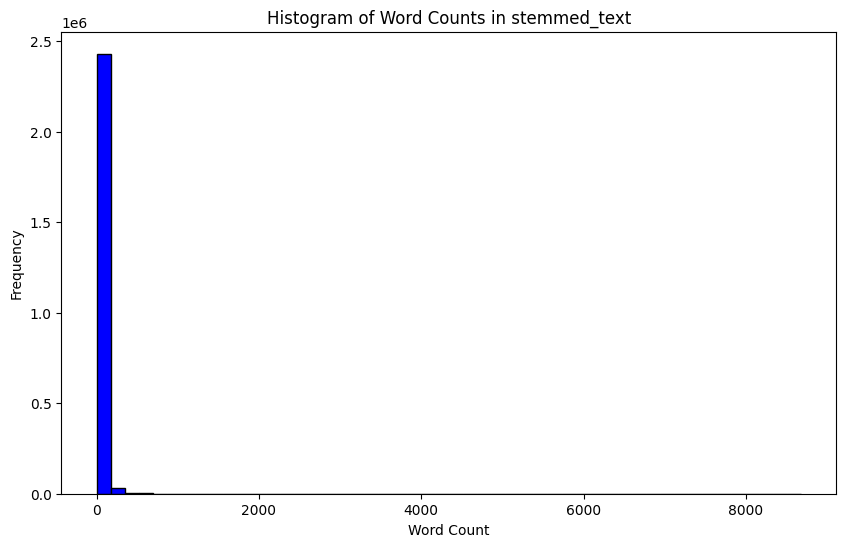

In [47]:
# Calculate the word counts for each row in 'stemmed_text'
word_counts = reddit_df4['stemmed_text'].progress_apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Word Counts in stemmed_text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [48]:
# Calculate the 80th percentile of word counts
percentile_80 = word_counts.quantile(0.80)

# Filter the dataframe to keep only rows with word counts less than or equal to the 80th percentile
reddit_df5 = reddit_df4[word_counts <= percentile_80]

# Display the shape of the filtered dataframe
print(reddit_df5.shape)

(1987011, 12)


  0%|          | 0/1987011 [00:00<?, ?it/s]

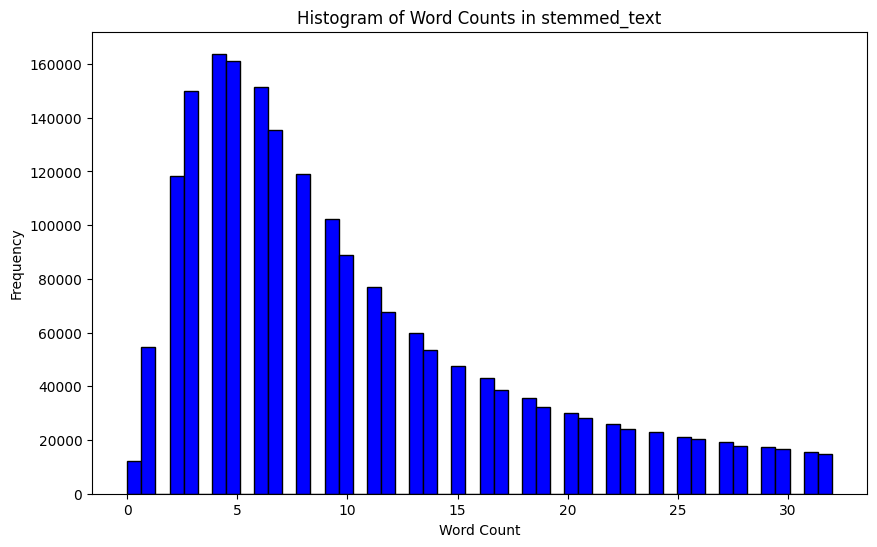

In [49]:
# Calculate the word counts for each row in 'stemmed_text'
filtered_word_counts = reddit_df5['stemmed_text'].progress_apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_word_counts, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Word Counts in stemmed_text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Now its much better, as the outliers have been removed. I may plan to add this to the 1.1) data processing section.

To save our processing progress, we will export the latest data into a .csv file.

In [50]:
reddit_df5.to_csv('../data/reddit_depression_dataset_cleaned.csv')